# Imports

In [1]:
%load_ext autoreload
%autoreload
from kofscraper import keywords_utils, load_utils, run_analysis, nlp_utils
from kofscraper.config import *
import polars as pl
from transformers import AutoTokenizer

/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-10 10:28:40.117585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Attempts

In [3]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url", "text")
MODEL_ID = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding = 'max_length', max_length = 512, truncation = True)

File ARGUS_chunk_p183.parquet is corrupted


In [6]:
lf.select(pl.len()).collect(engine="streaming").item()

1202228

In [4]:
from transformers import AutoTokenizer, AutoModel

MODEL_ID = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

model = AutoModel.from_pretrained(MODEL_ID, dtype = "auto", device_map = "auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast = True)

In [35]:
import torch 

def get_embeddings(texts, model, tokenizer):
    encoded = tokenizer(texts, padding = True, truncation = True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded)
    
    sentence_embeddings = model_output.last_hidden_state[:, 0, :]
    return sentence_embeddings

embeddings = get_embeddings(texts, model, tokenizer)

In [4]:
def tokenize(texts, tokenizer):
    return tokenizer(texts, padding = True, truncation = True, return_tensors="pt")

def embed(tokens, model):
    return(model(tokens))

# tok = tokenize(texts, tokenizer)
# print(tok)
# embs = embed(tok, model)
# print(embs)

# Pyarrow

In [10]:
import pyarrow.parquet as pq

parquet_file = pq.ParquetFile("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed/ARGUS_chunk_p1.parquet")

In [7]:
text = pq.read_table("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed/ARGUS_chunk_p1.parquet")

In [8]:
text = text["text"].to_numpy()

In [9]:
text = text.tolist()

### Re try

In [6]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url", "text")

MAX_CHARS = 5120
lf = lf.filter(pl.col("text") != "").with_columns(
    [pl.when(pl.col("text").str.len_chars() > MAX_CHARS)
     .then(pl.col("text").str.slice(0, MAX_CHARS))
     .otherwise(pl.col("text")).alias("text")]
)

lf.sink_parquet(pl.PartitionMaxSize("output/", max_size=2000), mkdir=True)

File ARGUS_chunk_p183.parquet is corrupted


In [ ]:
import glob
from pathlib import Path
import gc
import pyarrow as pa
import pyarrow.parquet as pq
import time
from datetime import timedelta
import os
from multiprocessing import Pool
import psutil
from typing import List
from sentence_transformers import SentenceTransformer

os.environ["TOKENIZERS_PARALLELISM"] = "true"


MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt").data
    

mem: List[str] = []

i = 0
out_path = Path("out")
out_path.mkdir(exist_ok=True)
n_files = len(glob.glob("output/000*.parquet"))
start = time.time()

with open("memory_usage.txt", "w+") as f:
    f.write("")

for path in glob.glob("output/000*.parquet"):
    i += 1
    df = pl.read_parquet(path).unique("text")
    texts = df["text"].to_list()
    toks = tokenize(texts)

    table = pa.Table.from_pydict(toks)
    out_name = out_path / f"tokens_{i:09d}.parquet"
    pq.write_table(table, out_name)
    end = time.time()
    eta = timedelta(seconds = (((end - start) / (i/n_files)) - (end - start)))
    process = psutil.Process()
    mem.append(process.memory_info().rss / 1024 / 1024)

    if (i%10 == 0):
        print(f"Done {(i*100/n_files):.1f}%, ({i} / {n_files})")
        print(f"ETA: {eta}")
        print(f"Memory usage: {process.memory_info().rss / 1024 / 1024} MB")
        print(f'Done file {path}')
    
    if (i%100 == 0): 
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding = 'max_length', max_length = 512, truncation = True, use_fast = True)
        with open("memory_usage.txt", "a") as f:
            f.write(",".join(str(m) for m in mem))
            mem = []

    del table, texts, toks
    gc.collect()
    

Done 1.7%, (10 / 587)
ETA: 0:08:42.130699
Memory usage: 12863.76171875 MB
Done file output/000000ce.parquet
Done 3.4%, (20 / 587)
ETA: 0:08:35.774330
Memory usage: 12879.83984375 MB
Done file output/000000bd.parquet
Done 5.1%, (30 / 587)
ETA: 0:08:31.918018
Memory usage: 12888.27734375 MB
Done file output/00000197.parquet
Done 6.8%, (40 / 587)
ETA: 0:08:30.293828
Memory usage: 12702.25390625 MB
Done file output/00000125.parquet
Done 8.5%, (50 / 587)
ETA: 0:08:28.797209
Memory usage: 12703.40234375 MB
Done file output/00000051.parquet
Done 10.2%, (60 / 587)
ETA: 0:08:19.617840
Memory usage: 12709.3515625 MB
Done file output/0000023c.parquet
Done 11.9%, (70 / 587)
ETA: 0:08:04.412433
Memory usage: 12709.796875 MB
Done file output/000000e9.parquet
Done 13.6%, (80 / 587)
ETA: 0:07:54.991160
Memory usage: 12711.4296875 MB
Done file output/0000003e.parquet
Done 15.3%, (90 / 587)
ETA: 0:07:47.521985
Memory usage: 12568.37109375 MB
Done file output/00000076.parquet
Done 17.0%, (100 / 587)
ETA:

Text(0.5, 0, 'Time')

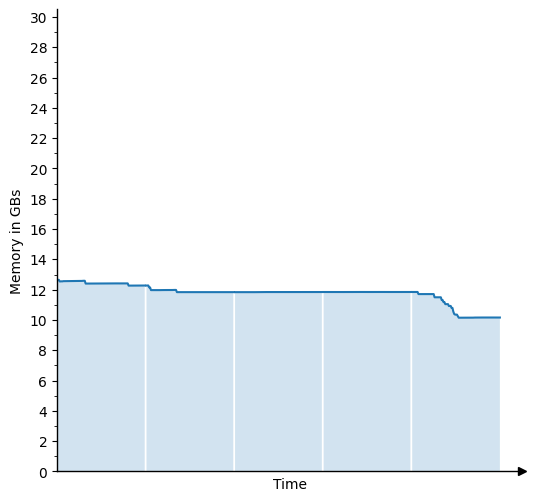

In [115]:
with open("memory_usage.txt") as f:
    mem = f.read()
mem = mem.split(",")

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

plt.style.use("./style.mplstyle")
plot = pd.DataFrame({"mem": mem})

plot["time"] = plot.index
plot["time"] = pd.to_numeric(plot["time"], errors="coerce")
plot["mem"]  = pd.to_numeric(plot["mem"], errors="coerce")
plot["mem"] = plot["mem"] / 1024

fig = plt.figure(figsize=(6,6))
ax = plt.subplot()
plt.plot("time", "mem", data = plot)
ax.set_xlim(0)
ax.set_ylim(0,30.5)
ax.set_xticks([])
# ax.xaxis.set_major_locator(MultipleLocator(100))
# ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on = False)
ax.fill_between(x = "time", y1="mem", y2=0, data = plot, alpha = 0.2)
plt.ylabel("Memory in GBs")
plt.xlabel("Time")

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

lf = pl.scan_parquet("out/tokens*.parquet")

In [3]:
texts = lf.select('input_ids').collect(engine = "streaming")["input_ids"].to_list()

In [34]:
embed = model.get_input_embeddings()

def get_tokens(lf, chunk_size):
    n_rows = lf.select(pl.len()).collect(engine = "streaming").item()
    for i in range(0, n_rows, chunk_size):
        tokens = lf.slice(i, chunk_size).select("input_ids").collect(engine = "streaming")["input_ids"].to_list()
        embs = embed(torch.tensor(tokens, dtype = torch.long))
        frame = pl.DataFrame({'embedding': embs})
        frame.write_parquet(f"embedding_{i}.parequt")

        del tokens, embs, frame
        gc.collect()

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"]

MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt")

In [20]:
toks = tokenize(texts)

In [ ]:
toks["input_ids"]

torch.Tensor

In [ ]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer
import torch

model = AutoModel.from_pretrained(MODEL_ID)

TypeError: 'str' object cannot be interpreted as an integer

In [34]:
df = pl.read_parquet("out/tokens_000000001.parquet")["input_ids"].to_list()

In [58]:
import torch
import pyarrow as pa
import pyarrow.parquet as pq

f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"]

enc = tokenizer(texts,return_tensors="pt", truncation = True, padding = True)

with torch.no_grad():
    model(**enc)

KeyboardInterrupt: 

# Make some order

Basically I want the whole output of the tokenizer, then pass it to model()

In [69]:
import pyarrow as pa
import pyarrow.parquet as pq
from transformers import AutoModel, AutoTokenizer


f = pq.read_table("output/00000000.parquet")
texts = f.to_pydict()["text"][0:10]

MODEL_ID = "sentence-transformers/distiluse-base-multilingual-cased-v1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def tokenize(t):
    return tokenizer(t, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt")

toks = tokenize(texts)

At this point we have tokens, now we need embeddings

In [78]:
from transformers import AutoModel, AutoTokenizer
import transformers
from sentence_transformers import SentenceTransformer
import torch

model = AutoModel.from_pretrained(MODEL_ID)
input_ids = torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["input_ids"])
attention_mask = torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["attention_mask"])
toks = transformers.tokenization_utils_base.BatchEncoding({"input_ids": input_ids, "attention_mask": attention_mask})

with torch.no_grad():
    output = model(**toks)

sentence_embeddings = output.last_hidden_state[:, 0, :].numpy()


KeyboardInterrupt: 

Ok this works. Now we only want to write the tokens to a file and be able to retrieve them as a transformers.tokenization_utils_base.BatchEncoding type

In [50]:
df2 = pl.read_parquet("out/tokens_000000001.parquet")

In [77]:
torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["input_ids"])
torch.tensor(pl.read_parquet("out/tokens_000000001.parquet").to_dict()["attention_mask"])

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])